# Se voglio ricostruire una coppia di elettroni di carica opposta come faccio?


In [3]:
#Prima cosa: giriamo il notebook precedente 
%run ../esercitazione_3/PP-trees_and_ntuples.ipynb

NameError: name 'download' is not defined

In [5]:
import ROOT
inputFile = ROOT.TFile("../datasets/DYJets.root","OPEN")
mytree = inputFile.trees.events

In [6]:
#Non solo l'output, anche il tree è presente!
mytree
mytree.GetEntries()

10000

## Ora facciamo un loop sugli eventi!

In [7]:

mytree.Print("jets*")

******************************************************************************
*Tree    :events    : events                                                 *
*Entries :    10000 : Total =         5662329 bytes  File  Size =    1718518 *
*        :          : Tree compression factor =   3.29                       *
******************************************************************************
*Br    0 :jets_size : jets_size/I                                            *
*Entries :    10000 : Total  Size=      40657 bytes  File Size  =       7285 *
*Baskets :        2 : Basket Size=      32000 bytes  Compression=   5.51     *
*............................................................................*
*Br    1 :jets_pt   : vector<float>                                          *
*Entries :    10000 : Total  Size=     215793 bytes  File Size  =     112788 *
*Baskets :        8 : Basket Size=      32000 bytes  Compression=   1.91     *
*...................................................

In [8]:
h_jet_mass = ROOT.TH1F("Jets_mass_0","Leading jet mass",100,0,40) 
for i in range (mytree.GetEntries()):
    mytree.GetEntry(i)
    #Ogni 100 eventi stampo a schermo il vettore dei jet!
    if(i%1000==0):print( "event #", i, "n jets ",mytree.jets_size, " pt: ",mytree.jets_pt)
    #Se c'è almeno 1 jet: stampo il 

    if(mytree.jets_size):
            jet_0 =ROOT.TLorentzVector()
            jet_0.SetPtEtaPhiE(mytree.jets_pt[0],mytree.jets_eta[0],mytree.jets_phi[0],mytree.jets_e[0])
            if(i%1000==0):print("leading jet pt",mytree.jets_pt[0]," mass? ",jet_0.M())
            h_jet_mass.Fill(jet_0.M())

event # 0 n jets  2  pt:  { 23.5252f, 21.2744f }
leading jet pt 23.525209426879883  mass?  5.780231232227896
event # 1000 n jets  2  pt:  { 132.482f, 123.424f }
leading jet pt 132.4822998046875  mass?  12.171880845745264
event # 2000 n jets  2  pt:  { 52.9363f, 44.1318f }
leading jet pt 52.93634796142578  mass?  6.571729939939291
event # 3000 n jets  1  pt:  { 32.7383f }
leading jet pt 32.738304138183594  mass?  6.479578478494318
event # 4000 n jets  4  pt:  { 77.3369f, 43.2297f, 36.9718f, 26.8002f }
leading jet pt 77.3369369506836  mass?  17.612279455459902
event # 5000 n jets  1  pt:  { 30.9888f }
leading jet pt 30.98876953125  mass?  3.0345546335572213
event # 6000 n jets  3  pt:  { 102.553f, 97.4465f, 25.9533f }
leading jet pt 102.55277252197266  mass?  12.561784171985517
event # 7000 n jets  1  pt:  { 89.6939f }
leading jet pt 89.69392395019531  mass?  12.463836696754655
event # 8000 n jets  2  pt:  { 24.9785f, 22.9679f }
leading jet pt 24.978546142578125  mass?  7.492171015892832

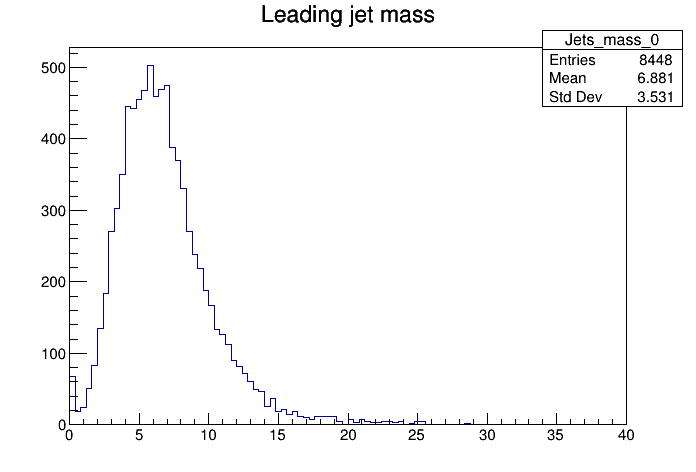

In [9]:
#Diseg
c1= ROOT.TCanvas()
c1.Draw()
h_jet_mass.Draw()

## Esercizio 1:

Proviamo a fare la somma vettoriale  di due elettroni di carica opposta e disegnarne la massa.
Facciamo lo stesso coi muoni.

### 1.1 Che forma ha questa distribuzione

### 1.2 Quante coppie avrò per evento?


## Esercizio 2: 

Proviamo a fittare la distribuzione che viene fuori, ad es. con gauss + expo, o... altro?


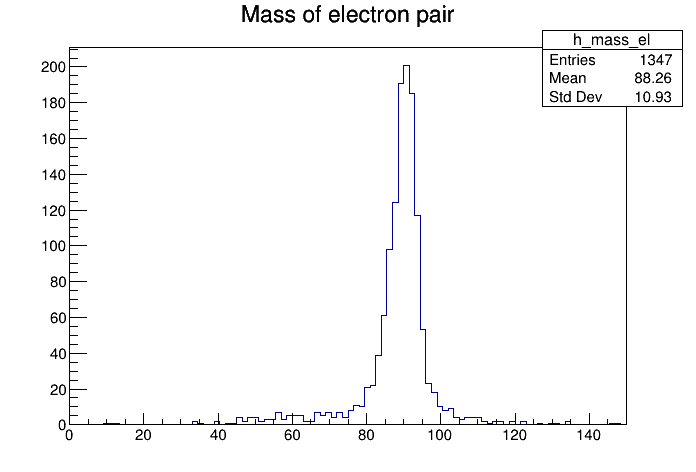

In [10]:
m_min=0
m_max=150
h_mass_el=ROOT.TH1F("h_mass_el","Mass of electron pair",100,m_min,m_max)
h_mass_mu=ROOT.TH1F("h_mass_mu","Mass of muon pair",100,m_min,m_max)



for i in range(mytree.GetEntries()):
#for i in range(100):
    mytree.GetEntry(i)
    for ei in range(mytree.electrons_size):
        for ej in range(ei):
            if mytree.electrons_charge[ei]* mytree.electrons_charge[ej]<0:
                e1=  ROOT.TLorentzVector()
                e2=ROOT.TLorentzVector()
                e1.SetPtEtaPhiE(mytree.electrons_pt[ei],mytree.electrons_eta[ei],mytree.electrons_phi[ei],mytree.electrons_e[ei])
                e2.SetPtEtaPhiE(mytree.electrons_pt[ej],mytree.electrons_eta[ej],mytree.electrons_phi[ej],mytree.electrons_e[ej])
                h_mass_el.Fill((e1+e2).M())


c1=ROOT.TCanvas("masses")
c1.Draw()
h_mass_el.Draw()

In [11]:
#Let's take a step further - a bit less monke

#1 Classe "particella"
class particle:
    def __init__(self, pt,eta,phi,e,charge,flavor):
        self.pt=pt
        self.eta=eta
        self.phi=phi
        self.e=e
        self.charge=charge
        self.flavor=flavor
        self.p4 = ROOT.TLorentzVector()
        self.p4.SetPtEtaPhiE(pt,eta,phi,e)
        
#2 Metodo per estrarla:    
def get_particle(tree=mytree,var="muontracks",index=0):
    flav_dict={"muontracks":13,"electrons":11}
    p = particle(getattr(tree,var+"_pt")[index],#getattr chiama dall'esterno un attributo con il nome preso come stringa
                getattr(tree,var+"_eta")[index],
                getattr(tree,var+"_phi")[index],
                getattr(tree,var+"_e")[index],
                getattr(tree,var+"_charge")[index] if hasattr(tree,var+"_charge") else 0,#nota: questo per i jet fallirà se non faccio qualcosa!
                -1*getattr(tree,var+"_charge")[index]*(flav_dict[var]) if hasattr(tree,var+"_charge") else 0)
    return p

def get_collection(tree=mytree,var="muontracks"):
    particles=[get_particle(tree,var,i) for i in range(getattr(tree,var+"_size"))]
    return particles

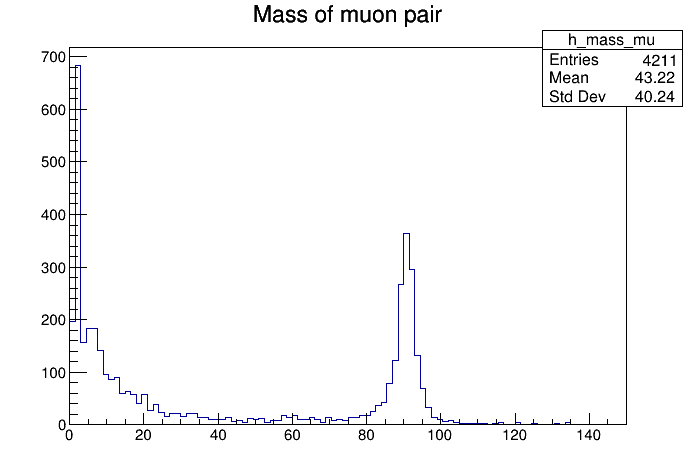

In [12]:
are_os = lambda x,y: x.charge*y.charge<0 #Uso lambda per vedere se sono segno opposto (opposite sign)
are_ss = lambda x,y: x.charge*y.charge>0 # o same sign (ss) -> quest'ultimo è ridondante in realtà!

h_mass_mu.Reset("ICES")

h_mass_mu_ss=h_mass_mu.Clone("h_mass_mu_os")


for i in range(mytree.GetEntries()):
#for i in range(100):
    mytree.GetEntry(i)
    muons=get_collection(mytree,"muontracks")
    electrons=get_collection(mytree,"electrons")
    jets=get_collection(mytree,"jets")
   
    for mi in range(len(muons)):
        for mj in range(mi):
            if(are_os(muons[mi],muons[mj])):
                h_mass_mu.Fill((muons[mi].p4+muons[mj].p4).M())
            else:
                h_mass_mu_ss.Fill((muons[mi].p4+muons[mj].p4).M())
            
c1.Draw()
h_mass_mu.Draw()

 FCN=56.4327 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=1.09224e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.42402e+03   1.26258e+02   3.40538e-01  -1.17196e-06
   2  p1           1.25200e+01   5.50627e-01   1.48541e-03  -3.67440e-04


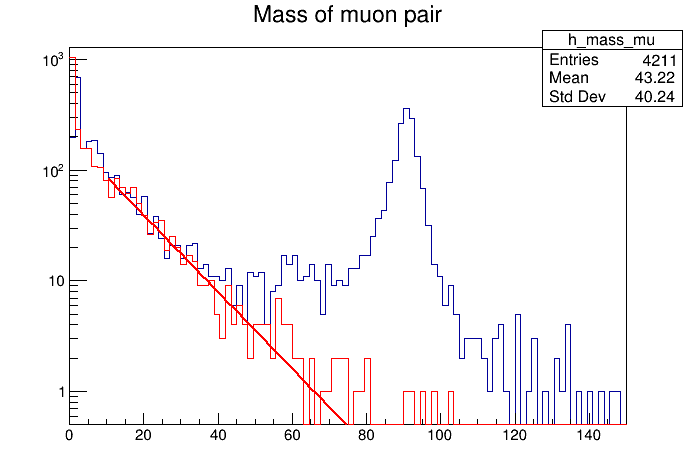

In [13]:
c1.Draw()
h_mass_mu_ss.SetLineColor(ROOT.kRed)
h_mass_mu_ss.Draw("same")
c1.SetLogy()

m_min_fit=10
bkg = ROOT.TF1("expo_bkg_1","[0]/[1]*exp(-x/[1])",m_min_fit,m_max)
bkg.SetParameters(1000,20)
h_mass_mu_ss.Fit(bkg,"SR")

 FCN=118.32 FROM MIGRAD    STATUS=FAILED        374 CALLS         375 TOTAL
                     EDM=671.546    STRATEGY= 1  ERROR MATRIX UNCERTAINTY 100.0 per cent
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.73782e+03   1.03365e+04   0.00000e+00  -1.06909e-02
   2  p1           6.09177e+02   9.69221e+00  -0.00000e+00   3.18416e-01
   3  p2          -9.35469e+01   1.24826e+03  -0.00000e+00   1.99115e-01
   4  p3           3.47281e+00   1.25643e+03   0.00000e+00  -2.49004e+01
   5  p4          -2.37550e-02   1.25644e+03  -0.00000e+00   2.58721e+02


Warning in <Fit>: Abnormal termination of minimization.


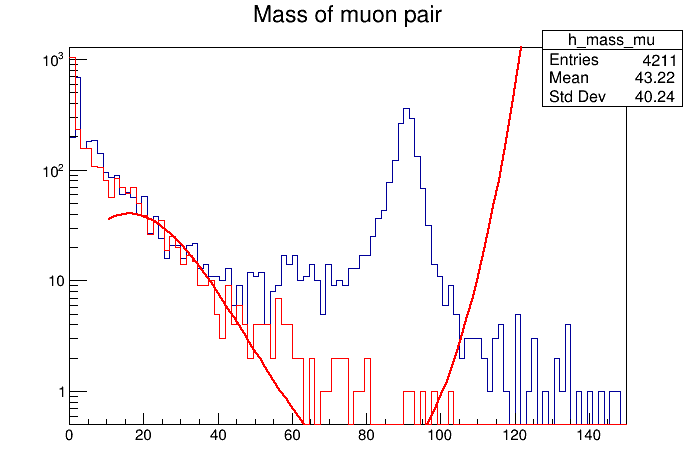

In [14]:
#Forse si può migliorare un po'...
m_min_fit= 10
bkg2 = ROOT.TF1("expo_bkg_2","[0]/[1]*exp(-([2]*x+[3]*x*x+[4]*x*x*x)/[1])",m_min_fit,m_max)
bkg2.SetParameters(1000,20,1,1,0.1)

h_mass_mu_ss.Fit(bkg2,"SR")
c1.Draw()

 FCN=152.249 FROM MIGRAD    STATUS=CONVERGED    1821 CALLS        1822 TOTAL
                     EDM=4.57301e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.5 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.22483e+04   5.53179e+02   2.05949e-01   4.44772e-07
   2  p1           1.54681e+01   2.99394e+00   1.43564e-03   9.62449e-04
   3  p2           2.29531e+03   6.92878e+01   7.34236e-03  -3.38575e-07
   4  p3           9.07868e+01   7.61438e-02   2.88454e-05  -3.51178e-03
   5  p4           2.94280e+00   1.00271e-01  -1.06051e-05  -9.73972e-04
   6  p5           3.37862e+00   4.48361e-01   2.49102e-04  -1.80283e-02
   7  p6          -5.42789e-02   6.65980e-03  -4.33421e-06  -1.07638e+00
   8  p7           2.77962e-04   3.39204e-05   2.43422e-08  -6.46821e+01


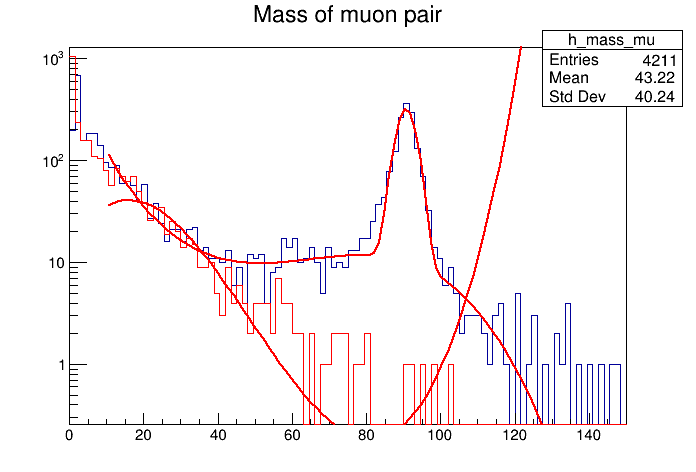

In [15]:
sigbkg = ROOT.TF1("sig_bkg","[0]/[1]*exp(-([5]*x+[6]*x*x+[7]*x*x*x)/[1])+[2]*1/([4]*TMath::Sqrt(2*TMath::Pi()))*exp(-(x-[3])*(x-[3])/(TMath::Sqrt(2)*[4]*[4]))",m_min_fit,m_max)
sigbkg.SetParameters(1000,20,1000,90,10,1,1,0.1)
c1.Draw()
h_mass_mu.Fit(sigbkg,"SR")


# Esercizio #1 

Proviamo a stimare il numero di eventi sotto il picco con il fit in due modi diversi : fit s+b, fit b.

# Esercizio #2 


Confrontiamo la nostra definizione di massa con la definizione 

# Esercizio #3


Definita la nostra selezione (es. massa >40 GeV) proviamo a studiare le altre features della muontrack:

chi2 -> chi2 del fit alla traccia
dz -> parametro di impatto lungo Z
dB -> parametro di impatto nel piano xy
isodeposits -> depositi calorimetrici intorno al muone

In [17]:
mytree.Scan("muontracks_chi2:muontracks_dz:muontracks_dB:muontracks_isoDeposits","","",50)

63

***********************************************************************
*    Row   * Instance * muontrack * muontrack * muontrack * muontrack *
***********************************************************************
*        0 *        0 *           *           *           *           *
*        1 *        0 * 0.9622507 * 0.0053055 * 0.0011121 *         0 *
*        1 *        1 * 0.5698273 * 0.0027536 * 0.0005146 * 1.1091781 *
*        2 *        0 *           *           *           *           *
*        3 *        0 *           *           *           *           *
*        4 *        0 *           *           *           *           *
*        5 *        0 *           *           *           *           *
*        6 *        0 * 1.0778735 * 0.0018064 * 0.0005451 *         0 *
*        6 *        1 * 1.3695157 * 0.0024244 * 0.0005252 *         0 *
*        7 *        0 *           *           *           *           *
*        8 *        0 *           *           *           *     

Type <CR> to continue or q to quit ==> Type <CR> to continue or q to quit ==> 

# Esercizio #4:

Proviamo su questo campione "mixed" di dati

In [13]:
dataFile= ROOT.TFile("Data.root")
#Nota: io l'ho scaricato in locale - potete fare lo stesso o usare il wget as you prefer :)

In [19]:
datatree= dataFile.trees.events
datatree.GetEntries()

NameError: name 'dataFile' is not defined

In [15]:
h_data_mass_mu_os=ROOT.TH1F("h_data_mu_os","Mass of muon pair, data",1500,m_min,m_max)
h_data_mass_mu_ss=h_data_mass_mu_os.Clone("h_data_mu_ss")

for i in range(datatree.GetEntries()):
#for i in range(100):
    datatree.GetEntry(i)
    muons=get_collection(datatree,"muontracks")
    electrons=get_collection(datatree,"electrons")
    jets=get_collection(datatree,"jets")
   
    for mi in range(len(muons)):
        for mj in range(mi):
            if(are_os(muons[mi],muons[mj])):
                h_data_mass_mu_os.Fill((muons[mi].p4+muons[mj].p4).M())
            else:
                h_data_mass_mu_ss.Fill((muons[mi].p4+muons[mj].p4).M())


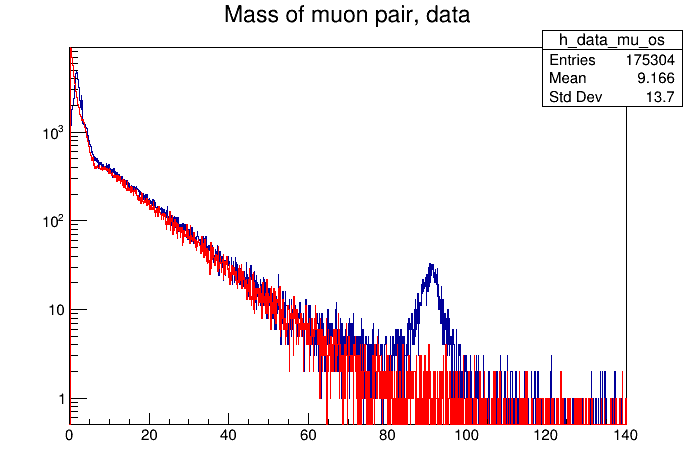

In [16]:
c1.Draw()
h_data_mass_mu_os.Draw()
h_data_mass_mu_ss.SetLineColor(ROOT.kRed)
h_data_mass_mu_ss.Draw("same")
h_data_mass_mu_os.GetXaxis().SetRangeUser(0,140)
#h_data_mass_mu_os.Rebin(2)
#h_data_mass_mu_ss.Rebin(2)
c1.Update()

